<a href="https://colab.research.google.com/github/kavyajeetbora/nlp_doc/blob/master/notebooks/02_simple_RAG_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# The URL of the PDF you want to download
!wget "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf" -O "Human Nutrition.pdf"

# Download the embeddings of the pdf
!wget https://github.com/kavyajeetbora/nlp_doc/raw/master/data/doc_embeddings.parquet -O "doc_embeddings.parquet"

--2024-04-15 06:35:02--  https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf
Resolving pressbooks.oer.hawaii.edu (pressbooks.oer.hawaii.edu)... 128.171.43.156
Connecting to pressbooks.oer.hawaii.edu (pressbooks.oer.hawaii.edu)|128.171.43.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26891229 (26M) [application/pdf]
Saving to: ‘Human Nutrition.pdf’

Human Nutrition.pdf 100%[===================>]  25.64M  14.6MB/s    in 1.8s    

2024-04-15 06:35:04 (14.6 MB/s) - ‘Human Nutrition.pdf’ saved [26891229/26891229]

--2024-04-15 06:35:04--  https://github.com/kavyajeetbora/nlp_doc/raw/master/data/doc_embeddings.parquet
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kavyajeetbora/nlp_doc/master/data/doc_embeddings.parquet [following]
--2024-04-15 06:35:05--  https://raw.githubu

In [2]:
!pip install -U -q sentence_transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer, util
import textwrap
!pip install -q PyMuPDF
import fitz ## import PyMuPDF

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.6 MB/s eta 0:00:00


In [7]:
df = pd.read_parquet('doc_embeddings.parquet')
df.sample(5)

,page_number,sentence_chunk,chunk_char_count,chunk word count,chunk_token_count,embedding
1112,792,This is partly due to an increase in metabolis...,536,82,134.00,"[-0.025120208, -0.018740341, -0.044263523, 0.0..."
523,347,through food. Genetic factors may also influen...,1053,160,263.25,"[-0.023104914, -0.052891638, -0.034369294, 0.0..."
1055,751,http:/ /www.cnpp.usda.gov/healthyeatingindex.h...,123,14,30.75,"[0.0006857966, 0.056924086, 0.05724726, 0.0488..."
1410,995,lead to symptoms that are also common to food ...,1051,160,262.75,"[0.072255544, -0.033986077, 0.07330872, 0.0363..."
747,508,Americans to eat healthy and be active by brin...,1557,239,389.25,"[-0.033343244, 0.10324867, 0.04194529, 0.08794..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   page_number        1680 non-null   int64  
 1   sentence_chunk     1680 non-null   object 
 2   chunk_char_count   1680 non-null   int64  
 3   chunk word count   1680 non-null   int64  
 4   chunk_token_count  1680 non-null   float64
 5   embedding          1680 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 78.9+ KB


Since the embeddings are stored as string in the csv file, we need to convert it back to numpy arrays so that we can further use it for processing

In [5]:
df['embedding'].iloc[0].shape

(384,)

Convert the embeddings to tensor object

In [13]:
a = np.stack(df['embedding'].to_list(), axis=0)
embedding  = torch.tensor(a).to(device)
print(f"Data type of the embedding array: {embedding.dtype}")
embedding

Data type of the embedding array: torch.float32


tensor([[-1.9507e-02, -1.8256e-02,  7.1660e-04,  ..., -3.9904e-02,
         -2.1543e-02, -4.3294e-02],
        [ 2.6605e-02,  1.8785e-03, -7.0033e-03,  ..., -2.1591e-02,
         -2.1828e-02, -6.9987e-02],
        [ 3.4971e-02,  4.0597e-02, -1.9747e-02,  ..., -3.5225e-02,
         -3.1397e-02, -4.6613e-02],
        ...,
        [-3.2258e-02, -2.4768e-02, -1.1571e-02,  ..., -1.3912e-05,
          3.9905e-02, -5.2110e-02],
        [-8.8627e-02, -6.6496e-02, -1.0430e-01,  ..., -3.0128e-02,
          8.4004e-02, -4.2208e-02],
        [-1.1203e-01, -4.9535e-02, -2.4897e-02,  ...,  1.2983e-02,
          4.6920e-02, -2.8276e-02]], device='cuda:0')

## Creating a semantic search engine


Here we will build a semantic search engine, given a query for example "Macronutrients" it will semantically search and return relevant passage


**dot product vs consine similarity ?**

Think geometrically. Cosine similarity only cares about angle difference, while dot product cares about angle and magnitude. If you normalize your data to have the same magnitude, the two are indistinguishable. Sometimes it is desirable to ignore the magnitude, hence cosine similarity is nice, but if magnitude plays a role, dot product would be better as a similarity measure. Note that neither of them is a "distance metric"

**when to use cosine and when to choose dot product ?**

Use consine similarity when the vectors are not normalized otherwise if they are already done just like in embedding models you can use dot product. Don't use consine similarity when the vectors are already normalized as it consine will perform an additional step in normalizing the vectors.


In [14]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [15]:
## Encode the query with the same embedding model
query = "Macronutrients"
query_encode = embedding_model.encode(query, convert_to_tensor=True).to(device)

## Get similarity scores
sim_score = util.dot_score(a=query_encode, b=embedding)

In [20]:
vals, indices = torch.topk(sim_score, k=5)

for i,v in zip(indices.flatten(),vals.flatten()):
    i,v = i.cpu().numpy(), v.cpu().numpy()
    print(f"Page number: {df.loc[i,'page_number']}")
    wrapped_text = textwrap.fill(df.loc[i, 'sentence_chunk'], 130)
    print(f"Sentence: {wrapped_text}")
    print(f'Similarity score: {v*100:.2f} %')
    print("-"*15)

Page number: 5
Sentence: Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients:
carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients
comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food
labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one
thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water
is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield
calories. Carbohydrates Carbohydrates are molecules composed of carbon, hydrogen,

Speed of vector search is very fast even with large vector size (10M embeddings)

we are doing an exhaustive search when comparing the similarity with query and all the embeddings even if they are fast in operation. But is very wastefull as we are overusing the resources of every search.

Recommended way is to use indexing techniques that can narrow down the search and make sure the resources are used efficiently.

A popular indexing library called [faiss](https://ai.meta.com/tools/faiss/) by facebook that can help acheive this. One of the technique used ny this library is [Approximate Nearest Neighbour (ANN)](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)


**Improving the results with Reranking model**:

We can improve the order of the similarity search with a reranking model. A model that has been trained specifically to take search results (example the top 25 semantic results) and rank them in order from most likely top-1 to least likely.

[Read more on rerank model](https://www.mixedbread.ai/blog/mxbai-rerank-v1)


## Return PDF page after search

Now in the section part, we will return the pdf page automatically after the search

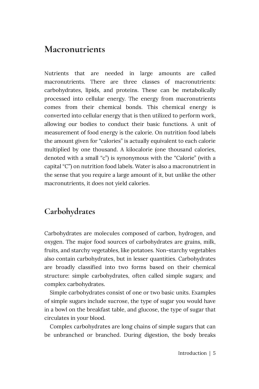

In [30]:
pdf_path = "Human Nutrition.pdf"
doc = fitz.open(pdf_path)
page_number = 5
page = doc.load_page(page_number+41) # note: page numbers of this PDF starts at -40

# get the image of the pdf page
image = page.get_pixmap(dpi=300)

## convert to image
img_array = np.frombuffer(image.samples_mv, dtype=np.uint8).reshape((image.h, image.w, image.n))

plt.imshow(img_array)
plt.axis('off')
plt.show()

## Getting a local LLM

How to choose the LLM model for text generation ?

There are plently of models regularly been updated and open-sourced. You can check out the [hugging face leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard)

However the choice of LLM also depends on the hardware that is available in the local machine

Also these models occupies large disk space. It is recommened to also look for [quantized version of these models](https://huggingface.co/TheBloke)

## Checking our local GPU memory availability


In [2]:
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB
